In [2]:
#This an old version of DNN model. The most updated version produces weird NN score distribution, but the old version works normally.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed for the reproducibility

In [3]:
#filename=("3j3b.root")
filename=("3j3b_sherpa.root")
file = ur.open(filename)
print(file.classnames())


{'ttbar;1': 'TTree'}


In [4]:
tree = file["ttbar"]
print(type(tree))
tree.show()
fulldata = tree.arrays(library="pd")

#shuffle the events [already done but just to be safe]
fulldata = fulldata.sample(frac=1).reset_index(drop=True)
print ("File loaded with ",fulldata.shape[0], " events ")

<class 'uproot.models.TTree.Model_TTree_v20'>
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
met_pt               | float                    | AsDtype('>f4')
bjet_E               | float                    | AsDtype('>f4')
el_E                 | float                    | AsDtype('>f4')
mu_E                 | float                    | AsDtype('>f4')
bjet_pt              | float                    | AsDtype('>f4')
el_pt                | float                    | AsDtype('>f4')
mu_pt                | float                    | AsDtype('>f4')
bjet_eta             | float                    | AsDtype('>f4')
el_eta               | float                    | AsDtype('>f4')
mu_eta               | float                    | AsDtype('>f4')
bjet_phi             | float                    | AsDtype('>f4')
el_phi               | float                    | AsDtype('>f4')
mu_phi      

In [4]:
#dump list of feature
fulldata.columns

Index(['dR_lep_close', 'dR_lep_far', 'mass_lep_close', 'mass_lep_far',
       'dR_bjet_close', 'dR_bjet_far', 'dR_lep_el', 'dR_lep_mu', 'mass_lep_el',
       'mass_lep_mu', 'dR_lep_1pt', 'dR_lep_2pt', 'mass_lep_1pt',
       'mass_lep_2pt', 'total_event_weight',
       'jet_GBHInit_topHadronOriginFlag'],
      dtype='object')

### Examine Pandas Dataset

In [5]:
#examine first few events
fulldata.head()

,dR_lep_close,dR_lep_far,mass_lep_close,mass_lep_far,dR_bjet_close,dR_bjet_far,dR_lep_el,dR_lep_mu,mass_lep_el,mass_lep_mu,dR_lep_1pt,dR_lep_2pt,mass_lep_1pt,mass_lep_2pt,total_event_weight,jet_GBHInit_topHadronOriginFlag
0,2.130234,3.401246,122.509346,194.451553,1.668660,2.259035,3.401246,2.130234,194.451553,122.509346,3.401246,2.130234,194.451553,122.509346,0.005394,4
1,1.210700,1.236700,121.424393,95.124390,2.283105,2.766619,1.210700,1.236700,121.424393,95.124390,1.210700,1.236700,121.424393,95.124390,0.007699,4
2,1.710726,2.583145,113.692665,74.462692,1.924557,3.586664,2.583145,1.710726,74.462692,113.692665,1.710726,2.583145,113.692665,74.462692,0.033415,4
3,2.649246,2.938221,179.380615,118.744514,0.770735,2.795970,2.938221,2.649246,118.744514,179.380615,2.649246,2.938221,179.380615,118.744514,0.005878,0
4,0.887961,3.348057,37.839214,103.277740,2.085716,2.218001,0.887961,3.348057,37.839214,103.277740,3.348057,0.887961,103.277740,37.839214,0.005189,4


# Event Selection

In [6]:
def extract(fulldata):
    weights = fulldata["total_event_weight"]
    del fulldata["total_event_weight"]
    target = fulldata["jet_GBHInit_topHadronOriginFlag"]
    del fulldata["jet_GBHInit_topHadronOriginFlag"]
    bjet_num = fulldata['bjet_number']
    del fulldata['bjet_number']
    event = fulldata["Event_number"]
    del fulldata["Event_number"]
    pT = fulldata[ 'bjet_pt']
    del fulldata[ 'bjet_pt']
    
    del fulldata[ 'met_phi']
    del fulldata[ 'bjet_phi']
    del fulldata[ 'el_phi']
    del fulldata[ 'mu_phi']
    del fulldata[ 'bjet_eta']
    del fulldata[ 'el_eta']
    del fulldata[ 'mu_eta']
    del fulldata[ 'bjet_E']
    del fulldata[ 'el_E']
    del fulldata[ 'mu_E']
    del fulldata[ 'met_pt']
    del fulldata[ 'el_pt']
    del fulldata[ 'mu_pt']
    
    del fulldata[  'dR_unb_close']
    del fulldata[  'dR_unb_far'] 
    target = list(target)
    for i in range(len(target)):
        if target[i] == 4:target[i] = 0
        else:target[i] = 1
    return weights,pd.Series(target),bjet_num,event,pT

In [7]:
target_eff = 4
if target_eff == 4: 
    fulldata = fulldata[fulldata.bjet_number>3]  
else:   fulldata = fulldata[fulldata.bjet_number==3]  
weights,target,bjet_num,event,pt = extract(fulldata)
#fulldata2,fulldata3 = drop_var(fulldata)
#coll_full = [fulldata,fulldata2,fulldata3]
print('fulldata: ',fulldata.shape)

fulldata:  (646643, 16)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.75 # fraction of sample used for training

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(fulldata, target, weights, train_size=train_size)

y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

print ("Xtrain Shape: ",X_train.shape)
print ("ytrain Shape: ",y_train.shape)
print ("Training Weights: ",weights_train.shape,"\n")
print ("Xtest Shape: ",X_test.shape)
print ("ytest Shape: ",y_test.shape)
print ("Test Weights: ",weights_test.shape)

Xtrain Shape:  (484982, 16)
ytrain Shape:  (484982,)
Training Weights:  (484982,) 

Xtest Shape:  (161661, 16)
ytest Shape:  (161661,)
Test Weights:  (161661,)


In [9]:
#X_test, X_val, y_test, y_val, weights_test, weights_val, = \
#    train_test_split(X_test, y_test, weights_test, train_size=0.5, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test) #applies the transformation calculated the line above

class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_test == i] *= 1/(1-train_size) #increase test weight to compensate for sampling
    
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())

class_weights_train: (236459.0, 248523.0)
Train : total weight sig 248523.0
Train : total weight bkg 248523.05
Test : total weight sig 331868.0
Test : total weight bkg 314776.0


# NN

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)), # input layer
    tf.keras.layers.Dense(128, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(128, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])

model.compile(loss="binary_crossentropy", optimizer="adam")

starting_time = time.time( )
the_fit = model.fit(X_train, y_train.values, epochs=10,
                     sample_weight=weights_train)
#not using validation dataset here; keras does not support val weights
#Solution: Define your own loss function that takes train and val loss! 

training_time = time.time( ) - starting_time
print("Training time:",training_time)

Epoch 1/10
15156/15156 [==============================] - 27s 2ms/step - loss: 0.5146
Epoch 2/10
15156/15156 [==============================] - 27s 2ms/step - loss: 0.5065
Epoch 3/10
15156/15156 [==============================] - 30s 2ms/step - loss: 0.5048
Epoch 4/10
15156/15156 [==============================] - 29s 2ms/step - loss: 0.5036
Epoch 5/10
15156/15156 [==============================] - 32s 2ms/step - loss: 0.5028
Epoch 6/10
15156/15156 [==============================] - 32s 2ms/step - loss: 0.5021
Epoch 7/10
15156/15156 [==============================] - 31s 2ms/step - loss: 0.5017
Epoch 8/10
15156/15156 [==============================] - 30s 2ms/step - loss: 0.5013
Epoch 9/10
15156/15156 [==============================] - 31s 2ms/step - loss: 0.5010
Epoch 10/10
15156/15156 [==============================] - 31s 2ms/step - loss: 0.5007
Training time: 370.33790278434753


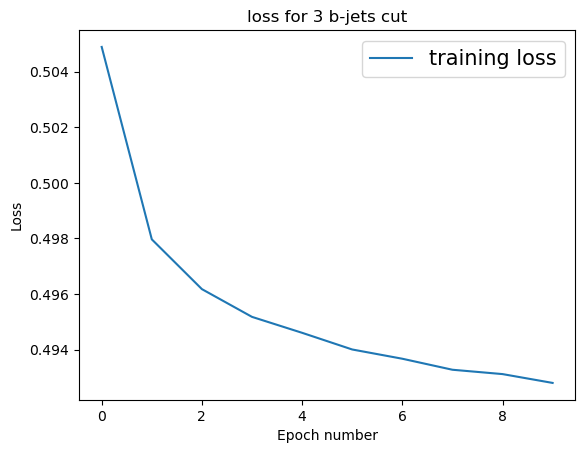

In [23]:
plt.plot(the_fit.history['loss'],label="training loss")
plt.title("loss for 3 b-jets cut")
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.legend(fontsize=15)

In [11]:
y_pred_test = model.predict(X_test).ravel()
y_pred_train = model.predict(X_train).ravel()

15156/15156 [==============================] - 18s 1ms/step


In [12]:
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"

Text(0.5, 1.0, 'Receiver Operating Characteristic')

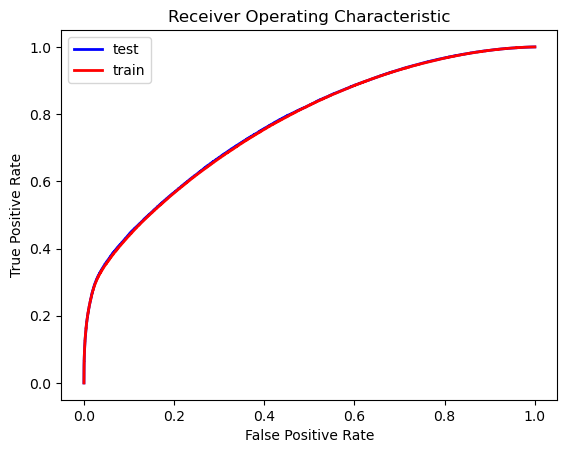

In [16]:
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
fpr2,tpr2,_ = roc_curve(y_true=y_train, y_score=y_pred_train,sample_weight=weights_train)
plt.plot(fpr, tpr, color='blue',lw=2,label='test')
plt.plot(fpr2, tpr2, color='red',lw=2,label='train')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('Receiver Operating Characteristic')

In [13]:
from math import sqrt
from math import log
def amsasimov(s,b):
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

In [13]:
int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
Z = max(vamsasimov)
print("Z:",Z)

Z: 64.21153788793835


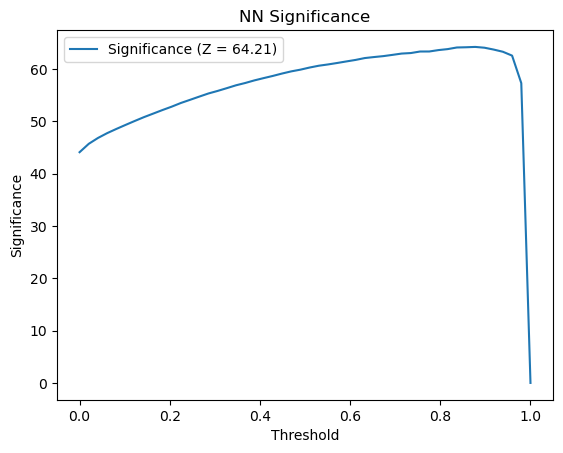

In [14]:
plt.plot(np.linspace(0,1,num=50),vamsasimov, label='Significance (Z = {})'.format(np.round(Z,decimals=2)))


plt.title("NN Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_xgb.pdf")
plt.show()

In [14]:
def compare_train_test(
    y_pred_train, y_train, y_pred, y_test, high_low=(0,1), 
    bins=30,xlabel="", ylabel="Arbitrary units", title="", 
    weights_train=np.array([]), weights_test=np.array([]),
    density=True):
    
    if weights_train.size != 0:
        weights_train_signal = weights_train[y_train == 1]
        weights_train_background = weights_train[y_train == 0]
    else:
        weights_train_signal = None
        weights_train_background = None
    plt.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='S (train)', weights=weights_train_signal) # alpha is transparancy
    plt.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=density,
                 label='B (train)', weights=weights_train_background)

    if weights_test.size != 0:
        weights_test_signal = weights_test[y_test == 1]
        weights_test_background = weights_test[y_test == 0]
    else:
        weights_test_signal = None
        weights_test_background = None
    hist, bins = np.histogram(y_pred[y_test == 1],
                                  bins=bins, range=high_low, density=density, weights=weights_test_signal)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=density, weights=weights_test_background)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')

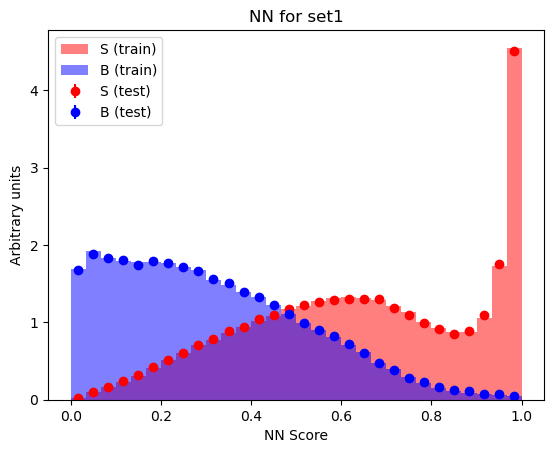

In [15]:
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN for set1", 
                   weights_train=weights_train.values, weights_test=weights_test.values)

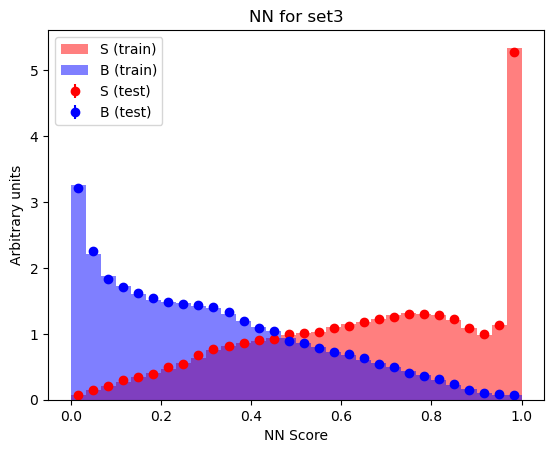

In [27]:

compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN for set3", 
                   weights_train=weights_train.values, weights_test=weights_test.values)

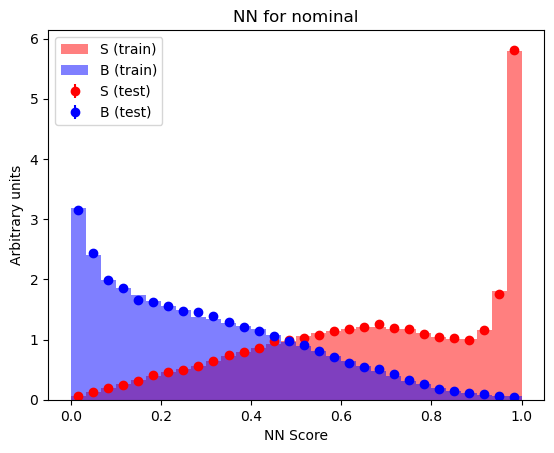

In [35]:
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN for nominal", 
                   weights_train=weights_train.values, weights_test=weights_test.values)